# MIE 1517 Progress Report - Team 9

## 1. Introduction

This project aims to enhance workplace safety in industrial and construction environments through a real-time moitoring system. The system will leverage advanded computer vision techniques, like YOLO, to ensure that workers are wearing personal protective equipment (PPE) and staying safe around hazardous tools and areas.
The project has the following three phases planned:
1. PPE Detection
2. PPE Compliance Verification
3. Hazard Zone Detection and Proximity Alert System

## 2. Data Collection

- **Data Source**:
    - We used the ["PPE Detection" dataset](https://universe.roboflow.com/ai-project-yolo/ppe-detection-q897z) available on Roboflow Universe, which contains labeled images for training YOLO-based object detection models.
- **Data Description**:
    - The dataset includes images labeled for detecting person and various types of PPE such as helmets, vests, gloves. These labels are essential for training the model to identify PPE usage.
    - **Data Format**: The images and annotations are formatted for YOLO, allowing direct integration with our model pipeline.
    - **Dataset Split**:
        - **Training Set**: 82% of the dataset, with 1,153 images.
        - **Validation Set**: 11% of the dataset, with 161 images.
        - **Test Set**: 7% of the dataset, with 96 images.
    - **Label Distribution**:
        - Person: 3,107 instances
        - Helmet: 2,057 instances
        - No Vest: 1,708 instances
        - Vest: 1,288 instances (Under represented)
        - No Helmet: 983 instances (Under represented)
    - This label distribution shows that some classes, such as "No Helmet" and "Vest," are under represented. This may introduce challenges in achieving balanced detection performance across all PPE types.


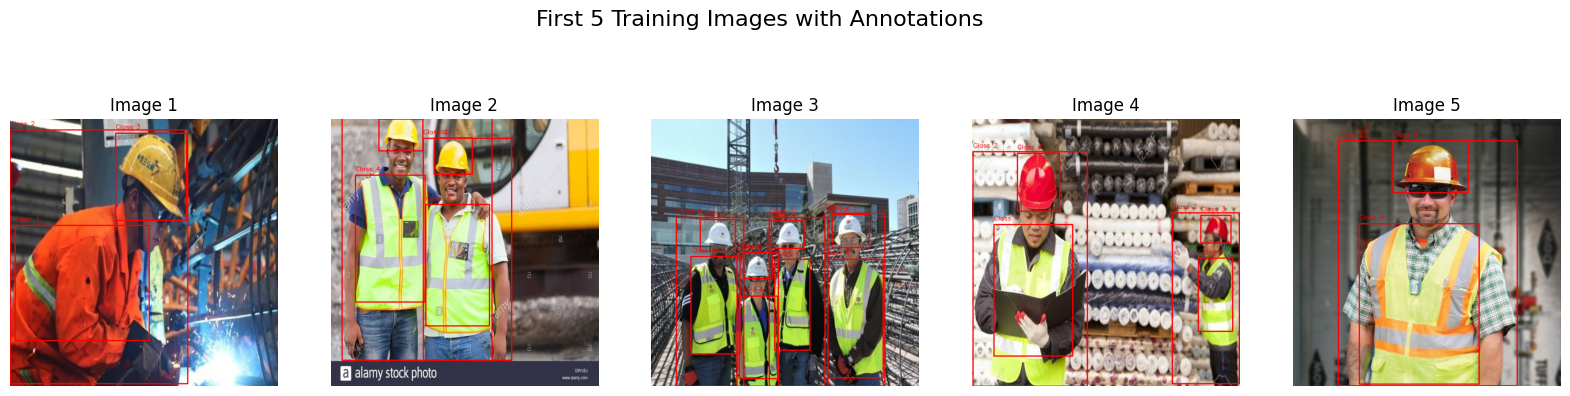

In [2]:
import cv2
import matplotlib.pyplot as plt
import os

image_path = "../dataset/ppe/train/images"
label_path = "../dataset/ppe/train/labels"

# Function to plot images with bounding boxes
def load_image_with_labels(image_file):
    # Load image
    img = cv2.imread(os.path.join(image_path, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    # Load corresponding label file
    label_file = image_file.replace(".jpg", ".txt")
    label_file_path = os.path.join(label_path, label_file)
    
    if os.path.exists(label_file_path):
        # Read label data and draw bounding boxes
        with open(label_file_path, "r") as f:
            for line in f:
                # Parse YOLO format (class x_center y_center width height)
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)
                
                # Convert YOLO format to bounding box coordinates
                img_h, img_w = img.shape[:2]
                x_center, y_center, width, height = (
                    x_center * img_w, y_center * img_h, width * img_w, height * img_h
                )
                x1, y1 = int(x_center - width / 2), int(y_center - height / 2)
                x2, y2 = int(x_center + width / 2), int(y_center + height / 2)
                
                # Draw the bounding box
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
                cv2.putText(img, f"Class {int(class_id)}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    return img

# Get the list of image files and select the first five

image_files = [f for f in os.listdir(image_path) if f.endswith(".jpg")]
first_five_images = image_files[:5]

# Plot the first five images with labels in a single subplot
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle("First 5 Training Images with Annotations", fontsize=16)

for i, image_file in enumerate(first_five_images):
    img = load_image_with_labels(image_file)
    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

plt.show()

## 3. Model Selection

- **Current Model**:
In our project, we have selected **YOLO v11** as our object detection model. This decision is based on it's advanced capabilities in real-time object detection.
- **Code Implementation**:
Below is the training code used for training YOLO using PPE Detection dataset from Roboflow. 


In [ ]:
from ultralytics import YOLO
import torch

# Load a model
model = YOLO("yolo11n.yaml")  # build a new model from YAML
model = YOLO("models/yolo11n-ppe-1108.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n.yaml").load("models/yolo11n-ppe-1108.pt")  # build from YAML and transfer weights

data_yaml_path = '../dataset/ppe/data.yaml'

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = model.train(data=data_yaml_path, epochs=300, imgsz=640, batch = 32, device = device)

## 4. Current Results

- **Model Summary**: YOLO11n, with 238 layers and 2,583,127 parameters, is relatively lightweight. At 6.3 GFLOPs, it’s computationally efficient, likely intended for faster inference on limited hardware while still aiming for high accuracy.

- **Overall Detection Performance**:

    - **Precision (P)**: Overall precision across classes is 0.893, which indicates that most detections are correct.
    - **Recall (R)**: The recall of 0.849 shows the model successfully identifies most instances, although there are still some missed detections.
    - **mAP50**: The mean Average Precision at an IoU threshold of 0.5 is 0.9, suggesting high accuracy in object detection.
    - **mAP50-95**: The average across a range of IoU thresholds is 0.575, indicating a slight decrease as the IoU threshold increases, typical in detection tasks.
- **Class-specific Performance**:

    - **No helmet** and **No vest**: Slightly lower precision and recall scores (0.874 and 0.863 in precision; 0.791 and 0.801 in recall, respectively), meaning the model may struggle more with identifying these safety violations compared to others.
    - **Person**: Highest scores across all metrics, with 0.915 precision, 0.889 recall, and 0.938 mAP50, reflecting strong performance in detecting people accurately.
    - **Helmet** and **Vest**: Strong performance, with precision and recall scores close to or above 0.9, and mAP50 values indicating accurate detections.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/15/Yolo11n_terminal_results.png" alt="Training Result" width="1500" height="300">

- **Confusion matrix** shows strong detection for "Person" (322 correct) and good performance for "No vest" (169), "Helmet" (177), and "Vest" (131). However, "No helmet" and "No vest" occasionally get misclassified as "Person" or "Background," with 17 and 24 instances, respectively. Background misclassification affects all classes, indicating room for improvement in distinguishing objects from complex backgrounds.

<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Yolo11n_confusion_matrix.png" alt="Confusion matrix" width="1300" height="1000">

- **Training and validation metrics**:
    - **Training Losses**:
        - Box Loss and DFL Loss: Both steadily decrease over the training iterations, indicating the model is learning to better predict bounding boxes.
        - Classification Loss: Decreases over time, with some fluctuations, showing improved class predictions.
    - **Validation Losses**:
        - Validation Box and Classification Loss: Both decrease consistently, reflecting good generalization without significant overfitting.
- Overall, the model shows effective learning, with stable high precision and recall, and steadily improving mAP, indicating that the training process was successful in enhancing both accuracy and generalization.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/24/Yolo11n_results.png" alt="Result">

### YOLOv11 Sample Usage and Observations 

We trained two versions of YOLOv11—**medium** and **nano**. 

- The **medium version** performs well in less crowded scenarios but struggles to detect individuals in **crowded images**, often ignoring some persons. 
- The **nano version** is lightweight and fast but frequently misclassifies categories like **vest vs. no vest** due to its smaller capacity.

**Next Steps**:
- Use an **ensemble approach** to combine the strengths of both models.
- Fine-tune models with **augmented datasets** focused on crowded scenarios and similar-class samples.
- Explore **post-processing techniques** like confidence threshold adjustments or additional classifiers to handle misclassifications.



image 1/1 e:\MIE\MIE1517\mie1517_project\reports\..\Safety-6\valid\images\00035_jpg.rf.bba1d9442afd07bf869f63614fbd05c0.jpg: 640x640 1 No helmet, 1 Person, 1 vest, 52.6ms
Speed: 4.1ms preprocess, 52.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 e:\MIE\MIE1517\mie1517_project\reports\..\Safety-6\valid\images\00060_jpg.rf.de7f93727784e5dac1cd4774dac20c40.jpg: 640x640 6 No helmets, 5 No vests, 14 Persons, 4 helmets, 9 vests, 16.9ms
Speed: 3.1ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 e:\MIE\MIE1517\mie1517_project\reports\..\Safety-6\valid\images\00085_jpg.rf.0ccaa5cf8e646f4d6222ce78e7151985.jpg: 640x640 1 No helmet, 1 Person, 1 helmet, 1 vest, 16.3ms
Speed: 3.4ms preprocess, 16.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 e:\MIE\MIE1517\mie1517_project\reports\..\Safety-6\valid\images\00119_jpg.rf.d566b7898dc73d438ef8b72a14faf335.jpg: 640x640 1 No helmet, 1 Person,

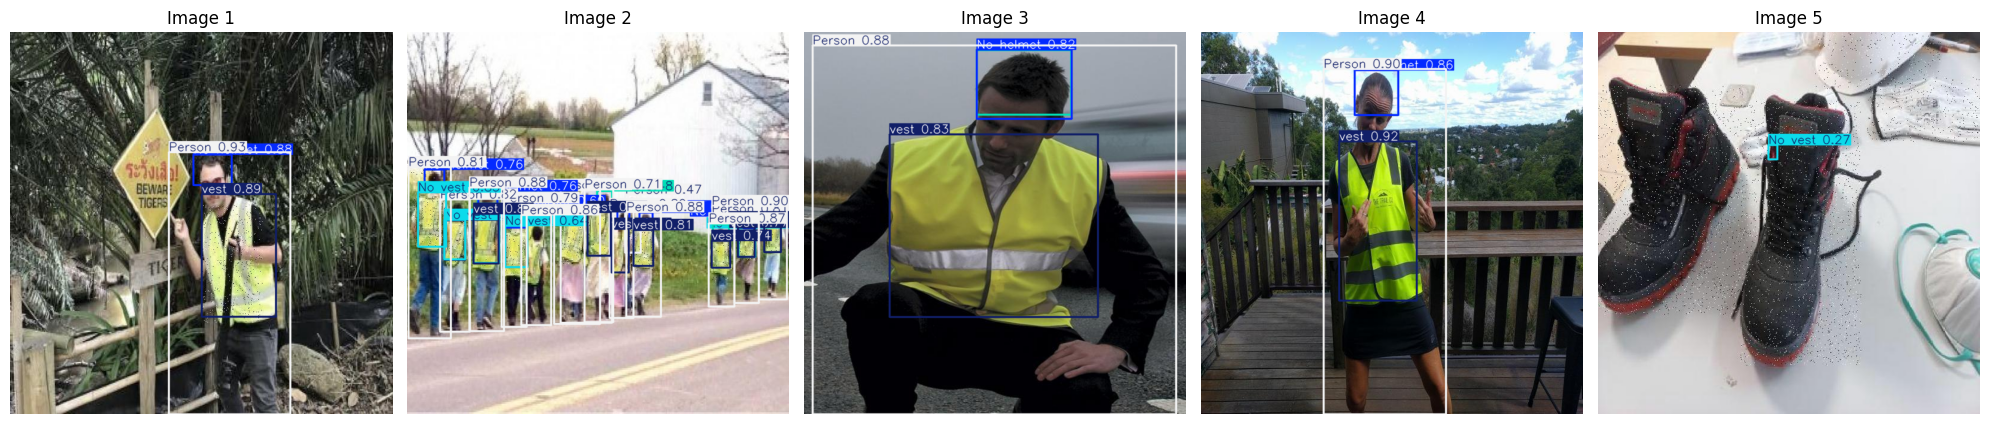

In [ ]:
from IPython.display import display, clear_output

clear_output(wait=True)
model = YOLO(r'..\checkpoints\yolo11n-ppe-1111.pt')  # Path to the best model weights

test_images_path = Path(r'..\Safety-6\valid\images') # yolo11 nano

test_images = list(test_images_path.glob("*.jpg"))

test_images = test_images[:5]

fig, axs = plt.subplots(1, len(test_images), figsize=(20, 5))

for i, image_path in enumerate(test_images):

    results = model(image_path)
    annotated_img = results[0].plot()
    annotated_img_rgb = annotated_img[:, :, ::-1]  
    axs[i].imshow(annotated_img_rgb)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

### PPE Compliance Check

### MiDas Sample Usage and Observation
- **MiDas**:
    - Pretrained MiDas model is currenly being used to get the depth map from the input image to identify the distance from the camera source to the workers.
    - The top row shows depth maps for five images, each with color gradients indicating depth variations. In these images, objects closer to the camera appear in warmer colors 
    
Overall, the MiDaS model has successfully captured depth information for these images, providing a color-coded representation of depth.

**Note**: Currenly `midas_core` is imported from the scripts we have in GitHub repo. The project on GitHub is set to private to ensure that only authorized team members can access and collaborate on the code. By keeping the repository private, we can prevent others in the class or outside the team from viewing or copying the work. Once the semester concludes, we will make the project public to allow others to access and learn from our work. Please let us know if you need access to our repo for grading purpose.

/home/home/school/MIE1517/mie1517_project/scripts/midas/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location=torch.devi

Model loaded, number of parameters = 345M
[PosixPath('../dataset/Safety-6/valid/images/Video4_272_jpg.rf.02a2acc82f87b49e1542edcfc0cd7d35.jpg'), PosixPath('../dataset/Safety-6/valid/images/Video4_30_jpg.rf.9e983ac6c0026272ceba26bc48ca8f39.jpg'), PosixPath('../dataset/Safety-6/valid/images/AightDuo0294_jpg.rf.84dc7eed6e275262009fa354ef937885.jpg'), PosixPath('../dataset/Safety-6/valid/images/Video4_281_jpg.rf.f82866e43a22a4b64d101019b96f7053.jpg'), PosixPath('../dataset/Safety-6/valid/images/Video4_45_jpg.rf.527a05e31d5a1a3efd115c79233711ba.jpg')]
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder


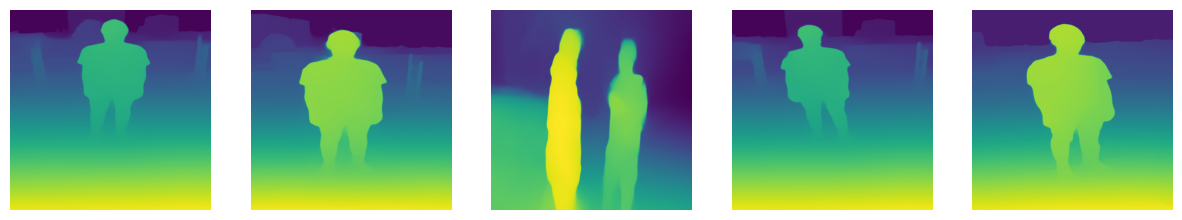

In [ ]:
# Sample Code to predict the depth map of the image using Midas
import sys
from pathlib import Path
import numpy as np

# Add the project directory to the Python path
sys.path.insert(1, '..')

from scripts.midas_core import MidasCore

# Load the MiDaS model
midas_model_path = '../checkpoints/dpt_beit_large_512.pt'
midas = MidasCore(midas_model_path)

# Lod the input image
test_images_path = Path('../dataset/Safety-6/valid/images')
test_images = list(test_images_path.glob("*.jpg"))


# Process each image to obtain depth maps and apply color mapping
depth_maps = [midas.get_depth(image) for image in test_images[:5]]
colored_depth_maps = [cv2.applyColorMap(np.uint8(depth_map), cv2.COLORMAP_VIRIDIS) for depth_map in depth_maps]

# Plot the depth maps in a single figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Convert BGR (OpenCV format) to RGB for Matplotlib
    ax.imshow(cv2.cvtColor(colored_depth_maps[i], cv2.COLOR_BGR2RGB))
    ax.axis("off")  

plt.show()

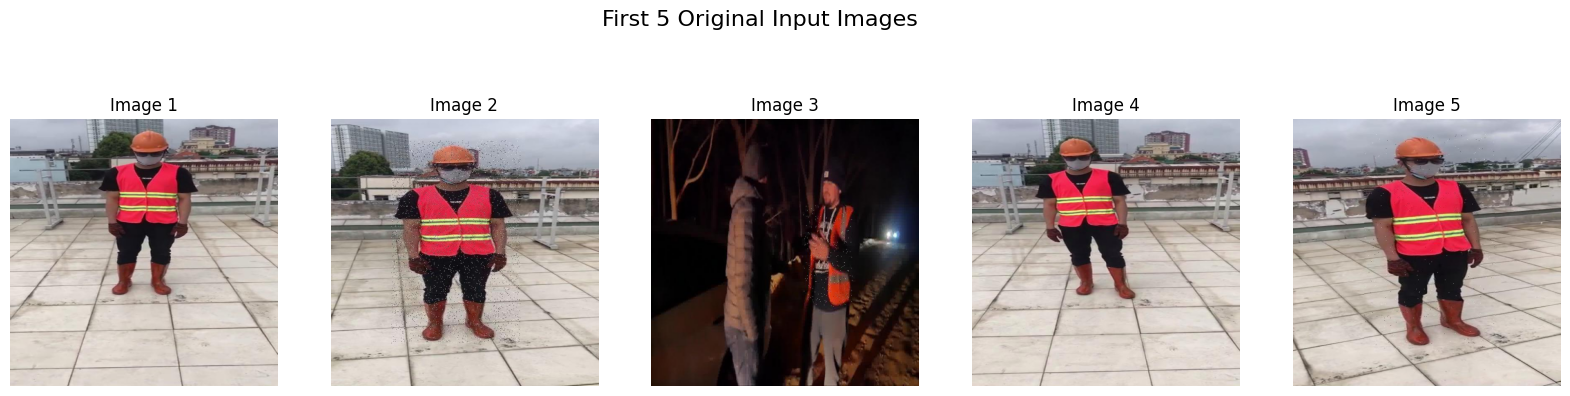

In [ ]:
# Plot the original images in a single figure with 5 subplots
test_images = test_images[:5]

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle("First 5 Original Input Images", fontsize=16)

for i, image_file in enumerate(test_images):
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

plt.show()

## 5. Feasibility and Next Steps